# RADARSAT-2 Charter Images
*Taken from documents:*

* **Packaging RADARSAT Acquisitions for the Charter.docx**
* **COS2_CSA_ICD.doc**
* **PR0541_A_COS-2_MPP_Manual_of_Operations.pdf**

As a part of the International Charter, Space and Major Disasters’ tools, the [Charter’s website](https://www.disasterscharter.org/web/guest/home) offers to the scientific community and general public an access to the images captured and metadata in the course of the activations. This is done through an interface called CGT ([Charter Geographic Tool](http://cgt.prod.esaportal.eu/charterng/#wmdr53ctcr1j:7)) which allows access to this information.

<img title="Charter Website" src="charter-website.png" width=600>

As one of the Charter’s members, the **CSA must populate this database** whenever we provide acquisitions in response to the requests we receive. This includes thumbnail- and quicklook-sized versions of the imagery we acquire, and needs to be submitted independently by the Agency. The Charter Operating System (COS2) has provided a means to programatically upload that data onto the site.

## 1. Requirements
Charter users need to upload two sets of data:

>Charter agencies’ can make:
>1. Their satellite Acquisition and Archive Plan (**AAP**) and 
>2. **Metadata/data products**
>available for specific Charter activations. Their upload in the COS-2 system can be made either through the web interface or through a *cURL* command line.

### a) AAP file (csv)
The AAP is a single `.csv` that represents details regarding the acquisitions taken by CSA for that Charter call.

#### Format
>`AGENCY,SATELLITE,SENSOR,MODE,ACQUISITION_DATE,ARCHIVE_OR_PROGRAM`

>`<AAAA>, <SSSSS>, <SESESESE>, <MMMM>, < dd MMMMM yyyy>, <PPPPPPPP>`

#### Submission
It can be sent to the COS-2 API my making a command-line call with cURL. For example, the following line submits the AAP to the COS-2 test server:
~~~bash
curl -i -k -X POST -H "Content-Type: multipart/form-data" --form ESA-<call-id>-AAP.csv="@<aap-file-path>" --basic https://<username>:<password>@disasterscharter.org/charterportlets/service/app/esa/<call-id>
~~~

### b) Metadata / data products (zip)
Contains extra information that depends on the satellite/instrument.

#### Contents
In section 4.4,
>Data product shall be submitted in a zip file. The flat zip file (i.e. the zip file shall not contain any folder structure) shall include:

>•	The metadata file (see format in section 4.2 and 4.3, file with fixed name `EOP.XML`)

>•	The thumbnail: optional (JPEG file with fixed name `ICON.JPG`), max 200 pixels wide

>•	The quicklook: mandatory (JPEG file with fixed name `PREVIEW.JPG`), max size 2 MB

>•	The product: optional (.PNG, .JPG, .TIF, .XML, .TXT, .DIM with name `PRODUCT.<extension>`)+

In CSA's case, the actual image product can only be delivered directly to the Point of Contacts, so we only need to package the first three items in that list.

#### Submission
This one can be sent to COS-2 with the following command, also to the test server:
~~~bash
curl -i -k -X POST --form product="@<product-file-path>" --form publicdata=false --basic https://<username>:<password>@disasterscharter.org /charterportlets/service/data-product/<agency>/<satellite>/<call-id>
~~~

## 2. Generate AAPs
For each activation, a single `.csv` file that contains summary info regarding the acquisitions needs to be generated. Written by past student Joshua Chan-Fee, they are generated directly inside SatOps' Charter Database (MS Access), found at: 

    W:\Satellite Operations\Data Management\Charter Activations.accdb

Unfortunately, I do not have access to the aforementioned folder at the moment, and I can't comment on it further.

The general rule applies however:

* Generate the appropriate `.csv` file for each activation in `Charter_Activations.accdb`
    - Making sure they are named  `$ACTIVATION_AAP.csv`, where `$ACTIVATION` is the activation number, e.g. `511_AAP.csv`.
    
We will be uploading them later, at [Section 6](#6.-Upload-to-COS-2-API) of this Notebook.

## 3. Generate metadata / data products
In this case, the metadata and data products are generated from files found inside the `.zip` archives of the actual data products. These files usually "weigh" multiple hundreds of MB, sometimes `<` 2GB. All we need, however, is three small files packaged alongside the satellite image:

* `product.xml` for the image metadata, 
* `product.kml` for the frame's geographical coordinates, and
* `BrowseImage.tif`, to generate the thumbnail and QuickLook images.

They unfortunately can't be accessed without downloading the whole `.zip`.

`(TO CONSIDER)` *This might be able to get all done without downloading the actual image file, but using the APT's archive files, submitted ACPs, as well as Quicklook images straight from NEODF website.*

### a) Metadata XML
The file `EOP.xml` can be populated from the metadata found in each product, in a file called `product.xml`.

|Variable name                                                                                                       |  Example  |
|--------------------------------------------------------------------------------------------------------------------|-----------|
|`<eop:parentIdentifier>`                                                                                            |`urn:ogc:def:EOP:CSA:RSAT1`|
|`<eop:status>`                                                                                                      |`ARCHIVED`
|`<gml:TimePeriod><gml:beginPosition>`                                                                               |`2008-09-02T11:59:12.145Z`
|`<gml:TimePeriod><gml:endPosition>`                                                                                 |`2008-09-02T11:59:12.145Z`
|`<eop:Platform><eop:shortName>`                                                                                     |`RADARSAT1`|
|`<eop:Instrument><eop:shortName>`                                                                                   |`SAR_RAD_1`|
|`<eop:Sensor><eop:OperationalMode>`                                                                                 |`FINE`|
|`<gml:Polygon><gml:exterior><gml:LinearRing>`   `<gml:posList>`                                                     |`30.52302 -90.27364 30.36339 -89.19232 28.97988 -89.47291 29.14067 -90.53881 30.52302 -90.27364`
|`<eop:browse><eop:BrowseInformation>`   `<eop:type>`                                                                |`THUMBNAIL`|
|`<eop:referenceSystemIdentifier   codeSpace="EPSG">`EPSG:4326`</eop:referenceSystemIdentifier>`   `<eop:fileName>`  |`ICON.JPG`|
|`<eop:BrowseInformation><eop:type>`                                                                                 |`QUICKLOOK`|
|`<eop:referenceSystemIdentifier   codeSpace="EPSG">`EPSG:4326`</eop:referenceSystemIdentifier>`     `<eop:fileName>`|`PREVIEW.JPG`|

Further details and lists of valid values are found in the COS-2 documentation (`COS-CSA-ICD.doc`), 

All these attributes can be taken directly by parsing `product.xml`, for the exception of `<eop:status>`, which can be inferred by the difference between acquisition and processing dates:

~~~xml
<sourceAttributes>
    <rawDataStartTime>2009-12-01T09:04:42.605591Z</rawDataStartTime>
~~~

vs.

~~~xml
<imageGenerationParameters>
    <generalProcessingInformation>
        <processingTime>2017-06-08T13:53:41.000000Z</processingTime>
~~~

is clearly an archive image, as it was processed almost 8 years after its original acquisition.

#### Parsing
We start by using the Python package **BeautifulSoup** to parse and easily access the XML file's contents:

In [56]:
from bs4 import BeautifulSoup
product_file = '../data/charter/product.xml'
product_kml = '../data/charter/product.kml'

with open(product_file) as f:
    xml_soup = BeautifulSoup(f, 'xml')
print(xml_soup.satellite)
with open(product_kml) as k:
    kml_soup = BeautifulSoup(k, 'xml')

<satellite>RADARSAT-2</satellite>


We need to construct a lookup table, so that we can map the COS-2 variables to the contents of the `product.xml` tags. We'll restrict it to RADARSAT-2 images only for now, as R1 imagery hasn't been used in Charter calls for over 7 years now.

We need to translate MDA's beam mode names into the appropriate COS-2 names (capitalization, etc.), which we'll do with a dictionary. Unfortunately, these do not contain the list of beam types added after R2's launch, so we'll go with the closest thing (arbitrarily decided) there is in that list.

In [57]:
beam_modes = {
    'Fine' : 'FINE',
    'Standard' : 'STANDARD',
    'Wide' : 'WIDE',
    'ScanSAR Narrow' : 'SCANSAR_NARROW',
    'ScanSAR Wide' : 'SCANSAR_WIDE',
    'Wide Fine' : 'WIDE_FINE',
    'Multi-Look Fine' : 'MULTI_LOOK_FINE',
    'Wide Multi-Look Fine': 'WIDE_MULTI_LOOK_FINE',
    'Ultrafine' : 'ULTRA_FINE',
    'Wide Ultrafine' : 'WIDE_ULTRA_FINE',
    'Spotlight A' : 'SPOTLIGHT',
    # Map these to others as they're not part of the COS-2 list
    'Wide Fine Quad Polarization' : 'WIDE_FINE',
    'Fine Quad Polarization' : 'FINE',
    'Wide Standard Quad Polarization' : 'WIDE',
    'Standard Quad Polarization' : 'STANDARD',
    'Extra Fine' : 'WIDE_FINE',
    'High Incidence' : 'STANDARD',
    'Low Incidence' : 'WIDE',
    }
beam_modes.get('Multi-Look Fine')

'MULTI_LOOK_FINE'

#### Compiling the variables

In [63]:
import datetime

def utc(string):
    """Given a string representing ISO 8601 time,
    returns datetime object.
    
    str -> datetime"""
    pattern = "%Y-%m-%dT%H:%M:%S.%fZ"
    return datetime.datetime.strptime(string, pattern)
    
def compare(start_time, end_time):
    """Compares the `rawDataStartTime` to the `processingTime`
    from a `product.xml` file, returns either 'ARCHIVED' or
    'PROGRAMMED'. Arbitrary cutoff date is 3 days.
    
    dt, dt -> str
    """
    days = 3
    duration = (end_time - start_time).seconds
    if duration > days * 86400:
        return 'ARCHIVED'
    return 'PROGRAMMED'

start_time = utc(xml_soup.rawDataStartTime.string)
end_time = utc(xml_soup.zeroDopplerTimeLastLine.string)
processing_time = utc(xml_soup.processingTime.string)
status = compare(start_time, processing_time)
beam_mode = beam_modes.get(xml_soup.acquisitionType.string)

# The following encodes digits as '9.163425407653519e+01', might be problematic
region = kml_soup.LinearRing.coordinates.string

#### Writing the XML

In [ ]:
string = """<?xml version="1.0" encoding="utf-8"?>
<sar:EarthObservation xmlns:eop="http://earth.esa.int/eop" xmlns:gml="http://www.opengis.net/gml" xmlns:sar="http://earth.esa.int/sar" version="1.2.2">
  <gml:metaDataProperty>
    <eop:EarthObservationMetaData>
      <eop:identifier>SAR123</eop:identifier>
      <eop:parentIdentifier>urn:ogc:def:EOP:CSA:RSAT2</eop:parentIdentifier>
      <eop:productType/>
      <eop:status>{0}</eop:status>
    </eop:EarthObservationMetaData>
  </gml:metaDataProperty>
  <gml:validTime>
    <gml:TimePeriod>
      <gml:beginPosition>{1}</gml:beginPosition>
      <gml:endPosition>{2}</gml:endPosition>
    </gml:TimePeriod>
  </gml:validTime>
  <gml:using>
    <eop:EarthObservationEquipment>
      <eop:platform>
        <eop:Platform>
          <eop:shortName>RADARSAT2</eop:shortName>
        </eop:Platform>
      </eop:platform>
      <eop:instrument>
        <eop:Instrument>
          <eop:shortName>SAR_RAD_2</eop:shortName>
        </eop:Instrument>
      </eop:instrument>
      <eop:sensor>
        <eop:Sensor>
          <eop:sensorType>RADAR</eop:sensorType>
          <eop:operationalMode>{4}</eop:operationalMode>
        </eop:Sensor>
      </eop:sensor>
    </eop:EarthObservationEquipment>
  </gml:using>
  <gml:target>
    <eop:Footprint>
      <gml:multiExtentOf>
        <gml:MultiSurface srsName="EPSG:4326">
          <gml:surfaceMembers>
            <gml:Polygon>
              <gml:exterior>
                <gml:LinearRing>
                  <gml:posList>{5}</gml:posList>
                </gml:LinearRing>
              </gml:exterior>
            </gml:Polygon>
          </gml:surfaceMembers>
        </gml:MultiSurface>
      </gml:multiExtentOf>
    </eop:Footprint>
  </gml:target>
</sar:EarthObservation>"""


metadata_table_R2 = {
    '<eop:parentIdentifier>' : 'urn:ogc:def:EOP:CSA:RSAT2',
    '<eop:status>' : status,
    '<gml:TimePeriod><gml:beginPosition>' : start_time,
    '<gml:TimePeriod><gml:endPosition>' : end_time,
    '<eop:Platform><eop:shortName>' : 'RADARSAT2',
    '<eop:Instrument><eop:shortName>' : 'SAR_RAD_2',
    '<eop:Sensor><eop:OperationalMode>' : beam_mode,
    '<gml:Polygon><gml:exterior><gml:LinearRing> <gml:posList>' : region,
    '<eop:browse><eop:BrowseInformation> <eop:type>' : 'THUMBNAIL',
    '<eop:referenceSystemIdentifier   codeSpace="EPSG">EPSG:4326</eop:referenceSystemIdentifier> <eop:fileName>' : 'ICON.JPG',
    '<eop:BrowseInformation><eop:type>' : 'QUICKLOOK',
    '<eop:referenceSystemIdentifier   codeSpace="EPSG">EPSG:4326</eop:referenceSystemIdentifier> <eop:fileName>' : 'PREVIEW.JPG'
}

### b) Create imagery thumbnails

### Loading the image
Apart from the (possibly multiple) satellite image(s) found in the zip file, there is also a 512-pixel wide QuickLook, `BrowseImage.tif`. As it is ~256kB (i.e. far less than 2MB), we can use it directly as the Quicklook image, and we'll resize it to generate the thumbnail (`<`200 px). 

To do this we'll use the Python package called **Pillow**. Its history is diverse as it is a fork and drop-in replacement of the now-unmaintained PIL (Python Imaging Library), and for that reason is imported as such in Python code. It is pre-installed in the Anaconda distribution, but can be installed with `pip install Pillow`.

In [22]:
import os
from PIL import Image, ImageFilter, ImageEnhance

file = '../data/charter/BrowseImage.tif'

raster = Image.open(file)
print('Image size:', raster.size, 'pixels')
print('Image file size: ', round(os.path.getsize(file) / 1024, 2), 'kB')

Image size: (512, 512) pixels
Image file size:  256.49 kB


Now let's see what we're working with. We'll plot this with the Jupyter Notebook `%matplotlib notebook` inline "magic", which loads **matplotlib** with interactive plots.

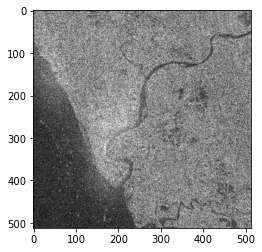

In [46]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

plt.imshow(np.asarray(raster), cmap='gray', interpolation='bilinear')

### Applying auto-contrast and resize
GDAL has loaded a pure numpy array from the TIF, so all we need to do is to apply a linear function (as in [linear map](https://en.wikipedia.org/wiki/Linear_map)) that boosts the contrast.

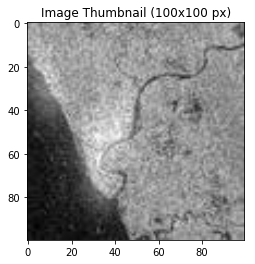

In [59]:
from glob import glob

def resize_and_contrast(file_in, file_out, resize=None):
    """Given input and output filenames, and `resize` in pixels,
    resizes and auto-contrasts the `file_in` image and saves
    it as `file_out`.
    
    Args:
        file_in: Filename of the image to be converted
        file_out: Output filename
        resize: Output size of the image (px), default=512
    Returns:
        None
    
    str, str, int -> None"""
    try:
        # Make a tuple out of the pixel size
        size = (resize, resize)
        
        image = Image.open(file_in)
        
        if resize:
            # Apply some blur to smooth out pixels
            image = image.filter(ImageFilter.GaussianBlur(radius=0.75))   
            # Resize the image to `size`
            image.thumbnail(size, resample=Image.LANCZOS)       
        # Apply some more contrast
        contrast = ImageEnhance.Contrast(image)
        image = contrast.enhance(1.3)  
        
        image.save(file_out, format=None)
    except IOError:
        print('Cannot resize', file_in, 'to', file_out)
        
resize_and_contrast(file, 'PREVIEW.JPG')  # Only apply contrast
resize_and_contrast(file, 'ICON.JPG', resize=100)

# See what it looks like
thumbnail = Image.open('ICON.JPG', 'r')
plt.title('Image Thumbnail (100x100 px)')
plt.imshow(np.asarray(thumbnail), cmap='gray', interpolation='bilinear')

## 5. Packaging the metadata / data products
Now we just need to package the two resized images and the XML file in one zip file, and we're good to go. As per the docs:

>Data product shall be submitted in a zip file. The flat zip file (i.e. the zip file shall not contain any folder structure) shall include:

>•	The metadata file (see format in section 4.2 and 4.3, file with fixed name `EOP.XML`)

>•	The thumbnail: optional (JPEG file with fixed name `ICON.JPG`), max 200 pixels wide

>•	The quicklook: mandatory (JPEG file with fixed name `PREVIEW.JPG`), max size 2 MB

>•	The product: optional (.PNG, .JPG, .TIF, .XML, .TXT, .DIM with name `PRODUCT.<extension>`)

## 6. Upload to COS-2 API
Upload to the COS-2 API can be done through the command line (also called "shell:), with the help of the program **cURL**. Instructions on how to install it can be found in [Section 7](#cURL).Of note, for this Notebook we are sending this only to the test server. The production server's address is actually located here:

>**OPERATIONAL Environment**

>•	agency =  CSA

>•	host = disasterscharter.org

>•	protocol = https

>•	username = MPP_CSA

>•	password =	*

>*the password is sent by the site operator. The script credentials are different from the EO-SSO account details used to access the web interface*. 

and invoked with the following:

~~~bash
curl -i -k -X POST --form product="@<product-file-path>" --form public-data=<false/true> –basic https://<username>:<password>@<host>/charter-portlets/service/data-product/<agency>/<satellite>/<call-id>
~~~

**P.S.** Adding an **exclamation mark** (!) before a line in Jupyter Notebook sends it to the **shell** (CMD.exe), in this case to invoke cURL.

## 7. Notes on Dependencies
### Anaconda
This notebook was built using the latest (as of writing) [Anaconda3 distribution](https://www.continuum.io/downloads) from Continuum Analytics. It is free of charge and runs only for the local user, so can be installed without admin priviledges for Windows users. It is slowly becoming the standard distribution for scientific and engineering Python uses, as it:

1. comes with many batteries included (scientific packages), and
2. comes with its own package manager, *conda*, similar to pip, but ships binaries that are tested on all major platforms.

In [62]:
import sys
sys.version

'3.6.0 |Anaconda custom (64-bit)| (default, Dec 23 2016, 11:57:41) [MSC v.1900 64 bit (AMD64)]'

### cURL
Taken from PR0541_A_COS-2_MPP_Manual_of_Operations.pdf:

>7. REST SERVICES
REST services provide a way to automate the upload of AAP or Metadata (with Products or links to
the Products) without logging into COS-2. The system offers web services that can be invoked directly
from the command line by using an HTTP tool such as cURL.
7.1.1 Installing cURL on Windows

<img src="img/curl.jpg" width=400>

>Go to http://curl.haxx.se/download.html, and download the correct installation file for the OD/MPP
Agency’s operating system (“Win64 – Generic” or “Win32 – Generic” for Windows).

<img src="img/Adding_PATH_to_Windows.jpg" width=400>

>Unzip the archive and add the location (should contain curl.exe) to the PATH system variable in order
to be

In [61]:
!curl --version

curl 7.52.1 (x86_64-pc-win32) libcurl/7.52.1 WinSSL zlib/1.2.8
Protocols: dict file ftp ftps gopher http https imap imaps ldap pop3 pop3s rtsp smb smbs smtp smtps telnet tftp 
Features: AsynchDNS IPv6 Largefile SSPI Kerberos SPNEGO NTLM SSL libz 
